In [1]:
# 1. Import libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import nltk
from nltk.corpus import stopwords
from imblearn.over_sampling import SMOTE

nltk.download('stopwords')
stop_words = set(stopwords.words('indonesian'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\runcodebagus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# 2. Load dataset
df = pd.read_csv("cleaned_split_sentiment.csv")
df.head()

,sentimen,tweet
0,-1,lagu bosan apa yang aku save ni huhuhuhuhuhuhu...
1,-1,kita lanjutkan saja diam ini hingga kau dan ak...
2,1,doa rezeki tak putus inna haa zaa larizquna ma...
3,1,makasih loh ntar kita bagi hasil aku 99 9 sisa...
4,-1,aku tak faham betul jenis orang malaysia yang ...


In [4]:
# 3. Setup stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [6]:
# 4. Preprocessing dengan stemming + stopwords
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+", "", text)       # remove URLs
    text = re.sub(r"[^a-z\s]", " ", text)            # remove symbols/numbers
    text = re.sub(r"\s+", " ", text).strip()         # remove extra whitespace
    tokens = text.split()
    tokens = [t for t in tokens if t not in stop_words]
    stemmed = [stemmer.stem(t) for t in tokens]
    return " ".join(stemmed)

df['clean_tweet'] = df['tweet'].apply(clean_text)

In [7]:
# 5. TF-IDF vectorizer
tfidf = TfidfVectorizer(ngram_range=(1,2), max_df=0.9, min_df=5)
X = tfidf.fit_transform(df['clean_tweet'])
y = df['sentimen']

In [8]:
# 6. SMOTE balancing
print("Distribusi sebelum balancing:\n", pd.Series(y).value_counts())
smote = SMOTE(random_state=42)
X_bal, y_bal = smote.fit_resample(X, y)
print("Distribusi setelah SMOTE:\n", pd.Series(y_bal).value_counts())

Distribusi sebelum balancing:
 sentimen
 0    5327
-1    2887
 1    2592
Name: count, dtype: int64
Distribusi setelah SMOTE:
 sentimen
-1    5327
 1    5327
 0    5327
Name: count, dtype: int64


In [12]:
# 7. Split data
X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.1, random_state=42)

In [13]:
# 8. Hyperparameter tuning
param_grid = {
    'alpha': [0.1, 0.5, 1.0],
    'fit_prior': [True, False]
}

grid_search = GridSearchCV(MultinomialNB(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

print("Best Params:", grid_search.best_params_)


Best Params: {'alpha': 0.5, 'fit_prior': False}


In [14]:
# 9. Evaluation
y_pred = best_model.predict(X_test)
print("Akurasi:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Akurasi: 0.6378986866791745
Classification Report:
               precision    recall  f1-score   support

          -1       0.61      0.70      0.65       511
           0       0.61      0.56      0.58       513
           1       0.69      0.66      0.67       575

    accuracy                           0.64      1599
   macro avg       0.64      0.64      0.64      1599
weighted avg       0.64      0.64      0.64      1599



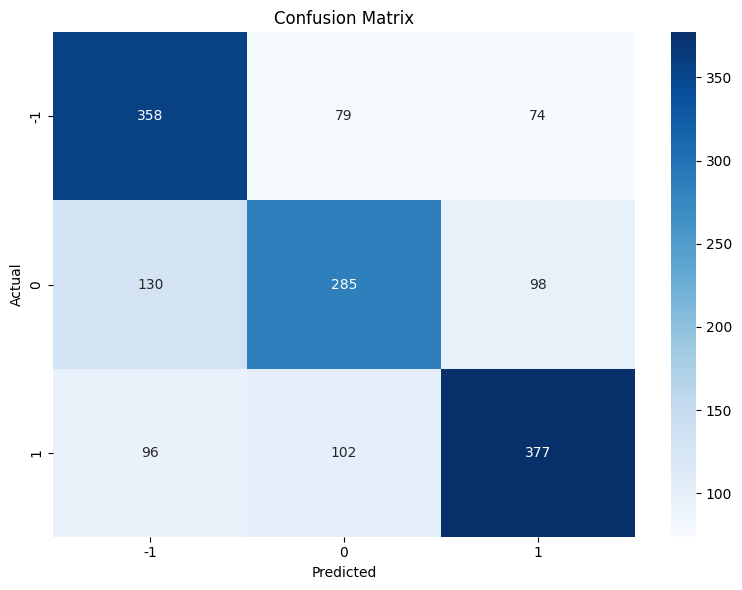

In [15]:
# 10. Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[-1,0,1], yticklabels=[-1,0,1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig("confusion_matrix_stemmed.png")
plt.show()

In [ ]:
# 11. Save model and vectorizer
joblib.dump(best_model, "nb_model_sastrawi.pkl")
joblib.dump(tfidf, "tfidf_sastrawi.pkl")



In [ ]:
# 12. Save cleaned dataset
df.to_csv("cleaned_dataset_with_stemming.csv", index=False)


In [ ]:
import joblib
import re
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.corpus import stopwords

# Load model dan vectorizer
model = joblib.load("nb_model_sastrawi.pkl")
vectorizer = joblib.load("tfidf_sastrawi.pkl")

# Setup stemmer dan stopwords
factory = StemmerFactory()
stemmer = factory.create_stemmer()
stop_words = set(stopwords.words('indonesian'))

# Preprocessing fungsi
def preprocess_input(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"[^a-z\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    tokens = text.split()
    tokens = [t for t in tokens if t not in stop_words]
    stemmed = [stemmer.stem(t) for t in tokens]
    return " ".join(stemmed)

# Tes kalimat
input_text = "Saya sangat kecewa dengan layanan ini"
cleaned = preprocess_input(input_text)
vector = vectorizer.transform([cleaned])
prediction = model.predict(vector)[0]

# Mapping hasil
label_map = {-1: "Negatif", 0: "Netral", 1: "Positif"}
print("Kalimat:", input_text)
print("Hasil Sentimen:", label_map[prediction])
